# Linear Probabilistic Model 

In [2]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from torch.autograd import Variable
%matplotlib inline
plt.style.use('ggplot')
from scipy.stats import norm
import time


In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
seed = 2001

## Normal-normal model
We start with a normal model,
\begin{eqnarray*}
  p(\theta) & \propto & 1, \\
  p(z_i) & = & \text{normal}(0, 1), \\
  \Omega_\mu (z_i, \theta) & = & \theta + \tau z_i, \\
  p(x_i \mid z_i, \theta) & = & \text{normal}(\Omega_\mu(z_i, \theta), \sigma^2),
\end{eqnarray*}
with latent variables $(\theta, z_{1:n})$. This model admits a (non-trivial) analytical expression for the posterior distribution, which is a multivariate Gaussian.

In [4]:
# Generate observations from a linear probabilistic model (i.e. normal-normal hierarchical).
n = 10000
tau = 1.155
sigma = 2.43
x = np.random.normal(size = (n, 1), scale = np.sqrt(tau**2 + sigma**2))

In [5]:
def vi_init(seed, lock_init = True):
    # NOTE: it seems torch "updates" these values once they're passed to a model,
    # so we need to generate the inits multiple times (with the same seed)
    torch.manual_seed(seed)
    nu_mean_theta = torch.randn(1)
    nu_sd_theta_log = torch.randn(1)
    alpha0 = torch.randn(1)  # torch.zeros(1)
    alpha = torch.randn(1)   # torch.zeros(1)
    xi_log = torch.randn(1)  # torch.zeros(1)

    if (lock_init):
        nu_mean_z = (alpha0 + alpha * x).reshape(n)
        nu_sd_z_log = xi_log.repeat(n)
    else:
        nu_mean_z = torch.rand(n)
        nu_sd_z_log = torch.rand(n)
    
    return nu_mean_theta, nu_sd_theta_log, alpha0, alpha, nu_mean_z, nu_sd_z_log, xi_log


Define distributions to estimate the ELBO.

In [6]:
# Not vectorized, simpler version (i.e. assume only one Monte Carlo estimator)
def log_joint(x, theta, z):
    return -0.5 * torch.sum(z**2) - 1 / (2 * sigma**2)\
              * torch.sum((x - theta - tau * z)**2)

def log_q(theta, z, nu_mean_theta, nu_sd_theta, nu_mean_z, nu_sd_z):
    log_q_theta = - torch.log(nu_sd_theta) - 1 / (2 * nu_sd_theta**2)\
                    * (theta - nu_mean_theta)**2
    log_q_z = torch.sum(- torch.log(nu_sd_z) - 1 / (2 * nu_sd_z**2) * (z - nu_mean_z)**2)
    return log_q_theta + log_q_z

In [7]:
# vectorized version for GPU
def log_joint_v(x, theta, z):
    return -0.5 * torch.sum(z**2, dim = 1) - 1 / (2 * sigma**2)\
              * torch.sum((x - theta[:, None] - tau * z)**2, dim = 1)

def log_q_v(theta, z, nu_mean_theta, nu_sd_theta, nu_mean_z, nu_sd_z):
    log_q_theta = - torch.log(nu_sd_theta) - 1 / (2 * nu_sd_theta**2)\
                    * (theta - nu_mean_theta)**2
    log_q_z = torch.sum(- torch.log(nu_sd_z) - 1 / (2 * nu_sd_z**2) * (z - nu_mean_z)**2,
                        dim = 1)
    return log_q_theta + log_q_z

### Factorized VI

In [8]:
# Tuning parameters for FVI
mc_samples = 100  # for Monte Carlo estimator of ELBO

In [9]:
class MCElbo_FVI(torch.nn.Module):
    def __init__(self, nu_mean_theta_init, nu_sd_theta_log_init,
                 nu_mean_z_init, nu_sd_z_log_init, mc_samples = mc_samples):
        super(MCElbo_FVI, self).__init__()

        self.nu_mean_theta = torch.nn.Parameter(nu_mean_theta_init, requires_grad = True)
        self.nu_sd_theta_log = torch.nn.Parameter(nu_sd_theta_log_init, requires_grad = True)
        self.nu_mean_z = torch.nn.Parameter(nu_mean_z_init, requires_grad = True)
        self.nu_sd_z_log = torch.nn.Parameter(nu_sd_z_log_init, requires_grad = True)

        self.mc_samples = mc_samples

        print(mc_samples)

    def generate_rand(self, m):
        eps_theta = torch.randn(m).to(device)
        eps_z = torch.randn((m, n)).to(device)
        return eps_theta, eps_z

    def reparam(self, eps_theta, eps_z):
        return eps_theta.mul(torch.exp(self.nu_sd_theta_log)).add(self.nu_mean_theta),\
               eps_z.mul(torch.exp(self.nu_sd_z_log)).add(self.nu_mean_z)

    def compute_elbo(self, x):
        eps_theta, eps_z = self.generate_rand(self.mc_samples)
        theta, z = self.reparam(eps_theta, eps_z)
        Elbo = log_joint_v(x, theta, z)\
          - log_q_v(theta, z, 
                    self.nu_mean_theta, torch.exp(self.nu_sd_theta_log),
                    self.nu_mean_z, torch.exp(self.nu_sd_z_log))
        return torch.mean(Elbo)
    
    def variational_parameters(self, _x):
        return self.nu_mean_theta, self.nu_sd_theta_log, self.nu_mean_z, self.nu_sd_z_log


In [10]:
def fvi_diagnose(model, x):
  # Evaluate the gradient of F-VI as a way to diagnose if the inference neural network
  # is sufficiently expressive.
    nu_mean_theta, nu_sd_theta_log, nu_mean_z, nu_sd_z_log = model.variational_parameters(x)

    model_benchmark = MCElbo_FVI(nu_mean_theta, nu_sd_theta_log, nu_mean_z, nu_sd_z_log,
                                 mc_samples = int(10000))

    loss = - model_benchmark.compute_elbo(x)
    loss.backward()
    print("\tFVI loss = ", loss.data)

    grads = []
    for param in model_benchmark.parameters():
        grads.append(param.grad.view(-1))
    grads = torch.cat(grads)

    return torch.norm(grads)

In [11]:
def run_fvi(seed, n_iter_optimizer, lock_init = True, print_output = False):
    torch.manual_seed(seed)

    nu_mean_theta_init, nu_sd_theta_log_init, _alpha0, _alpha, nu_mean_z_init,\
        nu_sd_z_log_init, _xi_log = vi_init(seed, lock_init)

    model = MCElbo_FVI(nu_mean_theta_init, nu_sd_theta_log_init, nu_mean_z_init,
                       nu_sd_z_log_init).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)
    x_torch = Variable(torch.tensor(x), requires_grad = False).reshape(n)
    x_torch = x_torch.to(device) # move to GPU, if available

    loss_saved = torch.empty((n_iter_optimizer,))
    grad_norm_saved = torch.empty((n_iter_optimizer,))

    start_time = time.time()
    for i in range(n_iter_optimizer):
        loss = - model.compute_elbo(x_torch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_saved[i] = loss.data

        if (False):  # track gradient for diagnostic purposes
            grads = []
            for param in model.parameters():
                grads.append(param.grad.view(-1))
            grads = torch.cat(grads)
            grad_norm_saved[i] = torch.norm(grads)

        if i % 1000  == 0 and print_output:
            print("loss", loss_saved[i])
    end_time = time.time()
    time_fvi = end_time - start_time

    fvi_gradient = fvi_diagnose(model, x_torch)

    return loss_saved, time_fvi, fvi_gradient  # , grad_norm_saved


In [12]:
# Can run a single run and check output
if (False):
    loss_saved, time_fvi = run_fvi(seed, n_iter_optimizer)

    # Get final result from training model
    print("loss", loss.data)
    mf_mean_theta = model.nu_mean_theta.data
    mf_sd_theta = torch.exp(model.nu_sd_theta_log).data
    print(mf_mean_theta, mf_sd_theta)

    # Expected results for marginal posterior of theta
    print(np.mean(x))  # mean
    print(np.sqrt((tau**2 + sigma**2) / n))  # sd

    plt.plot(loss_saved)
    plt.yscale("log")
    plt.xscale("log")

###  Amortized VI
We consider AVI using a polynomial inference function of degree up to 2.
In the amortized family,
\begin{equation*}
  q(z_i; x_i) = \text{normal}(f_\mu(x_i, \eta), f_{\sigma^2}(x_i, \eta)),
\end{equation*}
where
\begin{eqnarray*}
  f_\mu(x_i, \eta) & = & \alpha_0 + \alpha x_i + \beta x_i^2 \\
  f_{\sigma^2}(x_i, \eta) & = & \eta_{\sigma^2},
\end{eqnarray*}
meaning we need to optimize over three variational parameters, $\eta = (\alpha_0, \alpha, \beta, \eta_{\sigma^2})$, regardless of what $n$ may be.

In [18]:
class MCElbo_AVI(torch.nn.Module):
    def __init__(self, nu_mean_theta_init, nu_sd_theta_log_init,
                 alpha0_init, alpha_init, xi_log_init, poly_degree):
        super(MCElbo_AVI, self).__init__()

        self.poly_degree = poly_degree
        
        self.nu_mean_theta = torch.nn.Parameter(nu_mean_theta_init, requires_grad = True)
        self.nu_sd_theta_log = torch.nn.Parameter(nu_sd_theta_log_init, requires_grad = True)
        self.alpha0 = torch.nn.Parameter(alpha0_init, requires_grad = True)
        self.alpha = torch.nn.Parameter(alpha_init, requires_grad = True)
        self.beta = torch.nn.Parameter(torch.randn((1, 1)), requires_grad = True)
        self.nu_sd_z_log = torch.nn.Parameter(xi_log_init, requires_grad = True)
        
        self.mc_samples = mc_samples
        
   
    def generate_rand(self, m):
        eps_theta = torch.randn(m).to(device)
        eps_z = torch.randn((m, n)).to(device)
        return eps_theta, eps_z

    def reparam(self, eps_theta, eps_z, x, nu_mean_z):
        return eps_theta.mul(torch.exp(self.nu_sd_theta_log)).add(self.nu_mean_theta),\
               eps_z.mul(torch.exp(self.nu_sd_z_log)).add(nu_mean_z)

    def compute_elbo_sample(self, x, nu_mean_z):
        eps_theta, eps_z = self.generate_rand()
        theta, z = self.reparam(eps_theta, eps_z, x, nu_mean_z)

        elbo = log_joint(x, theta, z) - log_q(theta, z, self.nu_mean_theta,
                                              torch.exp(self.nu_sd_theta_log),
                                              nu_mean_z,
                                              torch.exp(self.nu_sd_z_log))
        return elbo        
    
    def variational_z(self, x):
        if (self.poly_degree == 0):
            nu_mean_z = self.alpha0
        if (self.poly_degree == 1):
            nu_mean_z = self.alpha0 + self.alpha.mul(x)
        if (self.poly_degree == 2):
            nu_mean_z = self.alpha0 + self.alpha.mul(x) + self.beta.mul(x**2)
        
        return nu_mean_z


    def compute_elbo(self, x):
        nu_mean_z = self.variational_z(x)
        eps_theta, eps_z = self.generate_rand(self.mc_samples)
        theta, z = self.reparam(eps_theta, eps_z, x, nu_mean_z)
        
        Elbo = log_joint_v(x, theta, z)\
          - log_q_v(theta, z, 
                    self.nu_mean_theta, torch.exp(self.nu_sd_theta_log),
                    nu_mean_z, torch.exp(self.nu_sd_z_log))
        return torch.mean(Elbo)   

    def variational_parameters(self, x):
        nu_mean_z = self.variational_z(x)
        nu_sd_z_log = self.nu_sd_z_log.repeat(nu_mean_z.shape)
        
        return self.nu_mean_theta, self.nu_sd_theta_log, nu_mean_z, nu_sd_z_log


In [19]:
def run_avi(poly_degree, seed, n_iter_optimizer, lock_init = True, print_output = False):
    torch.manual_seed(seed)
    nu_mean_theta_init, nu_sd_theta_log_init, alpha0_init, alpha_init,\
    __mean_z, _nu_sd_z_log, xi_log_init = vi_init(seed, lock_init)

    model_av = MCElbo_AVI(nu_mean_theta_init, nu_sd_theta_log_init,
                          alpha0_init, alpha_init, xi_log_init, poly_degree).to(device)
    optimizer = torch.optim.Adam(model_av.parameters(), lr = 1e-2)
    x_torch = Variable(torch.tensor(x), requires_grad = False).reshape(n)
    x_torch = x_torch.to(device) 

    loss_av_saved = torch.empty((n_iter_optimizer,))

    start_time = time.time()
    for i in range(n_iter_optimizer):
        loss_av = - model_av.compute_elbo(x_torch)
        optimizer.zero_grad()
        loss_av.backward()
        optimizer.step()
        loss_av_saved[i] = loss_av.data
        if i % 1000 == 0 and print_output:
            print("loss", loss_av.data)
    end_time = time.time()

    fvi_gradient = fvi_diagnose(model_av, x_torch)

    return loss_av_saved, end_time - start_time, fvi_gradient


In [21]:
# DRAFT CODE -- examine individual runs 

# n_iter_optimizer = int(5e3)

# seed = 2011
# loss_saved, time_fvi, fvi_grad, grad_norm_saved = run_fvi(seed, n_iter_optimizer, print_output = True)
# loss_avi_0_saved, time_avi_0, fvi_grad0 = run_avi(0, seed, n_iter_optimizer)
# loss_avi_1_saved, time_avi_1, fvi_grad1 = run_avi(1, seed, n_iter_optimizer)
# loss_avi_2_saved, time_avi_2 = run_avi(2, seed, n_iter_optimizer)

# save loss functions to csv
# n_algorithms = 4
# loss_all = torch.empty((n_iter_optimizer, n_algorithms))

# loss_all[:, 0] = loss_saved
# loss_all[:, 1] = loss_avi_0_saved
# loss_all[:, 2] = loss_avi_1_saved
# loss_all[:, 3] = loss_avi_2_saved

# np.save("deliv/lin_loss_" + str(seed), loss_all.detach().numpy())

# saved_times = np.array([time_fvi, time_avi_0, time_avi_1, time_avi_2])
# np.save("deliv/lin_time_" + str(seed), saved_times)

# print("Diagnostic:\n\tFVI = ", fvi_grad.data, 
#       "\n\tAVI (0) = ", fvi_grad0.data, 
#       "\n\tAVI (1) = ", fvi_grad1.data)

# plt.plot(loss_saved, label = 'FVI', alpha = 0.5)
# plt.plot(loss_avi_0_saved, label = 'd = 0', alpha = 0.5)
# plt.plot(loss_avi_1_saved, label = 'd = 1', alpha = 0.5)
# plt.legend(loc = "best")
# plt.yscale("log")


In [26]:
# function to run the experiments over multiple seeds
def run_experiment(seed, n_iter_optimizer, lock_init):
    loss_fvi, time_fvi, _ = run_fvi(seed, n_iter_optimizer, lock_init)
    loss_avi_0_saved, time_avi_0, _ = run_avi(0, seed, n_iter_optimizer, lock_init)
    loss_avi_1_saved, time_avi_1, _ = run_avi(1, seed, n_iter_optimizer, lock_init)
    loss_avi_2_saved, time_avi_2, _ = run_avi(2, seed, n_iter_optimizer, lock_init)

    n_algorithms = 4
    loss_all = torch.empty((n_iter_optimizer, n_algorithms))

    loss_all[:, 0] = loss_fvi
    loss_all[:, 1] = loss_avi_0_saved
    loss_all[:, 2] = loss_avi_1_saved
    loss_all[:, 3] = loss_avi_2_saved

    np.save("deliv/lin_loss_" + str(seed) + "_lock" + str(lock_init), loss_all.detach().numpy())

    saved_times = np.array([time_fvi, time_avi_0, time_avi_1, time_avi_2])
    np.save("deliv/lin_time_" + str(seed) + "_lock" + str(lock_init), saved_times)


In [27]:
init_seed = 1954
n_iter_optimizer = int(5e3)

for i in range(10):
    seed = init_seed + i
    print("seed: ", seed)
    run_experiment(seed, n_iter_optimizer, lock_init = False)


seed:  1954
100
10000
	FVI loss =  tensor(6147.5432, device='cuda:0', dtype=torch.float64)
10000
	FVI loss =  tensor(7233.6868, device='cuda:0', dtype=torch.float64)
10000
	FVI loss =  tensor(6088.6146, device='cuda:0', dtype=torch.float64)
10000
	FVI loss =  tensor(6088.6687, device='cuda:0', dtype=torch.float64)
seed:  1955
100
10000
	FVI loss =  tensor(6446.7229, device='cuda:0', dtype=torch.float64)
10000
	FVI loss =  tensor(7239.5578, device='cuda:0', dtype=torch.float64)
10000
	FVI loss =  tensor(6095.2450, device='cuda:0', dtype=torch.float64)
10000
	FVI loss =  tensor(6095.4882, device='cuda:0', dtype=torch.float64)
seed:  1956
100
10000
	FVI loss =  tensor(6090.4158, device='cuda:0', dtype=torch.float64)
10000
	FVI loss =  tensor(7232.2938, device='cuda:0', dtype=torch.float64)
10000
	FVI loss =  tensor(6087.9968, device='cuda:0', dtype=torch.float64)
10000
	FVI loss =  tensor(6088.3910, device='cuda:0', dtype=torch.float64)
seed:  1957
100
10000
	FVI loss =  tensor(6243.6017,

### Analyze results

In [18]:
plt.style.use('seaborn-white')  # seaborn-v0_8-white

# font_size = 24
params = {'axes.labelsize': 18,'axes.titlesize':25, 'legend.fontsize': 20, 'xtick.labelsize': 15,
          'ytick.labelsize': 15}
plt.rcParams.update(params)

linewidth = 4


/tmp/ipykernel_3493470/2572776544.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')  # seaborn-v0_8-white


#### Results for a single seed

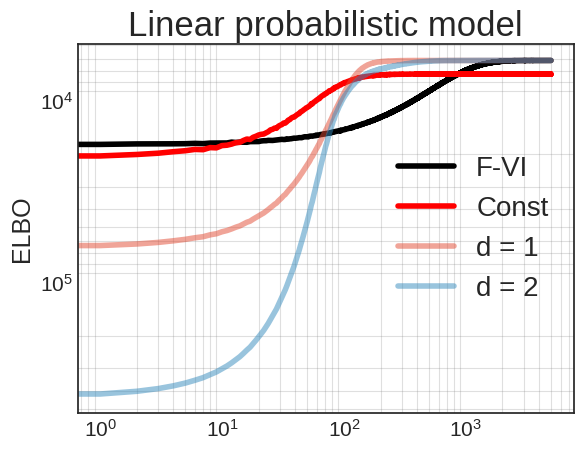

In [19]:
# read saved input from a single file (for illustrative purposes)
seed = 1959
lock_init = False
loss_all = np.load("deliv/lin_loss_" + str(seed) + "_lock" + str(lock_init) + ".npy")
# CHECK -- is it ok to use pickle = True

loss_saved = loss_all[:, 0]
loss_avi_0_saved = loss_all[:, 1]
loss_avi_1_saved = loss_all[:, 2]
loss_avi_2_saved = loss_all[:, 3]

fig, ax =  plt.subplots()


ax.plot(loss_saved, label = 'F-VI', linewidth = linewidth,
        color = 'black')
ax.plot(loss_avi_0_saved, label = 'Const', linewidth = linewidth, color = 'red')
ax.plot(loss_avi_1_saved, label = 'd = 1', alpha = 0.5, linewidth = linewidth)
ax.plot(loss_avi_2_saved, label = 'd = 2', alpha = 0.5, linewidth = linewidth)
plt.yscale("log")
plt.xscale("log")
plt.title("Linear probabilistic model")
# plt.xlabel("Iteration")
plt.ylabel("ELBO")
plt.gca().invert_yaxis()
plt.legend(loc = "right")

plt.grid(which = 'minor', visible = 'true', c = 'grey', alpha = 0.25)
plt.savefig("to_discuss/elbo_lin_normal_" + str(seed) + ".pdf", bbox_inches='tight')
plt.show()


In [22]:
def mean_window(loss, index_center, window):
    return np.mean(loss[(index_center - window):(index_center + window)])

def sd_window(loss, index_center, window):
    return np.std(loss[(index_center - window):(index_center + window)]) 

In [23]:
# Get asymptotic ELBO
index_center = 4500
window = 500
print("FVI: ", mean_window(loss_saved, 4500, window), " +/- ",
     sd_window(loss_saved, 4500, window))
print("d = 0: ", mean_window(loss_avi_0_saved, 4500, window), " +/- ",
     sd_window(loss_avi_0_saved, 4500, window))
print("d = 1: ", mean_window(loss_avi_1_saved, 4500, window), " +/- ",
     sd_window(loss_avi_1_saved, 4500, window))
print("d = 2: ", mean_window(loss_avi_2_saved, 4500, window), " +/- ",
     sd_window(loss_avi_2_saved, 4500, window))

FVI:  6090.304  +/-  0.56181294
d = 0:  7232.3623  +/-  4.779482
d = 1:  6087.993  +/-  0.046761114
d = 2:  6087.996  +/-  0.048420817


In [24]:
## Estimate of the convergence
# If oracle = False, compare subsequent windows.
def iter_convergence(loss, rel_tol = 0.01, init_iteration = 10, window = 10,
                     grid = 10, max_iteration = 5000, oracle = True, set_target = 0):
    iteration = init_iteration
    tol = 0
    diff = tol + 1
    while(diff > tol and iteration < max_iteration):
        iteration += grid
        if (oracle):
            target = set_target
        else:
            target = mean_window(loss, iteration - grid, window)

        tol = rel_tol * abs(target)
        diff = abs(mean_window(loss, iteration, window) - target)
        # print("diff:", diff)
        # print("tol:", tol)
    return iteration

# Q: should we report convergence to F-VI's solution or for each individual solution?
def iter_conv_wrapper(loss, loss_benchmark, rel_tol = 0.01, window = 10):
    return iter_convergence(loss, oracle = True, rel_tol = rel_tol,
                            set_target = mean_window(loss_benchmark, 4500, window))


In [25]:
print("FVI:", iter_conv_wrapper(loss_saved, loss_saved))
print("d = 0:", iter_conv_wrapper(loss_avi_0_saved, loss_saved))
print("d = 1:", iter_conv_wrapper(loss_avi_1_saved, loss_saved))
print("d = 2:", iter_conv_wrapper(loss_avi_2_saved, loss_saved))


FVI: 2000
d = 0: 5000
d = 1: 220
d = 2: 500


#### Results across multiple seeds

In [28]:
# Get results across multiple seeds
init_seed = 1954
num_seed = 10
lock_init = False  # Both options have saved files
num_seed = 10
n_algorithms = 4
num_tol = 3
rel_tol = np.array([0.5, 0.1, 0.01])

iter_to_conv = np.empty((num_seed, n_algorithms, num_tol))
Elbo_final = np.empty((num_seed, n_algorithms)) 

for i in range(num_seed):
    loss_all = np.load("deliv/lin_loss_" + str(init_seed + i) + "_lock" + str(lock_init) + ".npy")

    for j in range(n_algorithms):
        Elbo_final[i, j] = mean_window(loss_all[:, j], 4500, window)
        for k in range(num_tol):
            # Use F-VI as the benchmark for the asymptotic ELBO
            iter_to_conv[i, j, k] = iter_conv_wrapper(loss_all[:, j], loss_all[:, 0], rel_tol[k])


In [29]:
print("median iter:\n", np.median(iter_to_conv, axis = 0))
print("min iter:\n", np.min(iter_to_conv, axis = 0))
print("max iter:\n", np.max(iter_to_conv, axis = 0))
print(np.mean(Elbo_final, axis = 0))

median iter:
 [[ 550. 1200. 2135.]
 [ 115. 5000. 5000.]
 [ 115.  180.  365.]
 [ 165.  395.  700.]]
min iter:
 [[ 480. 1110. 1960.]
 [  20. 5000. 5000.]
 [  20.   70.  200.]
 [  40.  100.  190.]]
max iter:
 [[1390. 2950. 4160.]
 [ 210. 5000. 5000.]
 [ 270.  340.  580.]
 [ 370.  620.  900.]]
[6172.80493164 7233.93647461 6089.5940918  6089.71582031]


In [30]:
# Get final Elbo
np.min(Elbo_final, axis = 0)

array([6088.47802734, 7232.23925781, 6087.99169922, 6087.99609375])